In [1]:
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# prepare data

In [2]:
import os
import cv2

def crop_and_resize_images(images_root, masks_root, detections_root, output_images_root, output_masks_root, resize_shape):

    # Ensure output directories exist
    os.makedirs(output_images_root, exist_ok=True)
    os.makedirs(output_masks_root, exist_ok=True)

    # Iterate through each patient directory
    for patient_id in os.listdir(images_root):
        patient_images_dir = os.path.join(images_root, patient_id)
        patient_masks_dir = os.path.join(masks_root, patient_id)
        patient_detections_dir = os.path.join(detections_root, patient_id)

        if not os.path.isdir(patient_images_dir) or not os.path.isdir(patient_detections_dir):
            print(f"Skipping {patient_id}: Missing images or detection files")
            continue

        # Create output directories for this patient
        patient_output_images_dir = os.path.join(output_images_root, patient_id)
        patient_output_masks_dir = os.path.join(output_masks_root, patient_id)
        os.makedirs(patient_output_images_dir, exist_ok=True)
        os.makedirs(patient_output_masks_dir, exist_ok=True)

        # Process each image in the patient's directory
        for image_name in os.listdir(patient_images_dir):
            image_path = os.path.join(patient_images_dir, image_name)
            mask_path = os.path.join(patient_masks_dir, image_name)
            detection_file = os.path.join(patient_detections_dir, f"{image_name.split('.')[0]}.txt")

            if not os.path.exists(detection_file) or not os.path.exists(mask_path):
                print(f"Skipping {image_name} for {patient_id}: Missing detection or mask")
                continue

            # Load the detections (bounding boxes)
            with open(detection_file, "r") as f:
                bboxes = f.readlines()

            # Load image and mask
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if image is None or mask is None:
                print(f"Skipping {image_name} for {patient_id}: Unable to load image or mask")
                continue

            # Process each bounding box
            for idx, bbox in enumerate(bboxes):
                x_min, y_min, x_max, y_max = map(int, bbox.strip().split(","))

                # Crop the image and mask based on the bounding box
                cropped_image = image[y_min:y_max, x_min:x_max]
                cropped_mask = mask[y_min:y_max, x_min:x_max]

                # Resize the cropped image and mask
                resized_image = cv2.resize(cropped_image, resize_shape)
                resized_mask = cv2.resize(cropped_mask, resize_shape)

                # Create the new filename based on patient ID, image name, and bounding box index
                base_name = os.path.splitext(image_name)[0]  # Extract the name without the extension
                output_image_name = f"{patient_id}_{base_name}_{idx+1}.png"  # Save as patient_id_imageName_index.png
                output_mask_name = f"{patient_id}_{base_name}_{idx+1}.png"  # Same naming for mask

                # Save resized image and mask
                cv2.imwrite(os.path.join(patient_output_images_dir, output_image_name), resized_image)
                cv2.imwrite(os.path.join(patient_output_masks_dir, output_mask_name), resized_mask)

            print(f"Processed {image_name} for patient {patient_id}")

    print("Processing complete!")


In [3]:
crop_and_resize_images(
    images_root="/kaggle/input/computer-vision-project/train/images",
    masks_root="/kaggle/input/computer-vision-project/train/masks",
    detections_root="/kaggle/input/computer-vision-project/train/detections",
    output_images_root="/kaggle/working/cropped_images_train",
    output_masks_root="/kaggle/working/cropped_masks_train",
    resize_shape=(256, 256)  # Resize to 256x256
)

Processed 70.png for patient Subject_9
Processed 73.png for patient Subject_9
Processed 75.png for patient Subject_9
Skipping 100.png for Subject_9: Missing detection or mask
Processed 76.png for patient Subject_9
Processed 80.png for patient Subject_9
Skipping 1.png for Subject_9: Missing detection or mask
Skipping 10.png for Subject_9: Missing detection or mask
Processed 81.png for patient Subject_9
Processed 69.png for patient Subject_9
Processed 77.png for patient Subject_9
Processed 72.png for patient Subject_9
Processed 71.png for patient Subject_9
Processed 74.png for patient Subject_9
Skipping 101.png for Subject_9: Missing detection or mask
Processed 78.png for patient Subject_9
Skipping 0.png for Subject_9: Missing detection or mask
Processed 79.png for patient Subject_9
Processed 148.png for patient Subject_5
Processed 142.png for patient Subject_5
Processed 133.png for patient Subject_5
Skipping 100.png for Subject_5: Missing detection or mask
Processed 138.png for patient 

In [4]:
import os
import random
import matplotlib.pyplot as plt
import cv2

def show_random_cropped_images(cropped_images_root, num_images=5):

    all_images = []

    # Collect all image paths from patient directories
    for patient_id in os.listdir(cropped_images_root):
        patient_dir = os.path.join(cropped_images_root, patient_id)
        if os.path.isdir(patient_dir):
            all_images.extend([
                os.path.join(patient_dir, img) 
                for img in os.listdir(patient_dir) 
                if img.lower().endswith(('.png', '.jpeg', '.jpg'))
            ])

    if not all_images:
        print("No images found in the specified directory.")
        return
    
    random.seed(42)
    # Select random images to display
    selected_images = random.sample(all_images, min(num_images, len(all_images)))

    # Display the images
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(selected_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper color display
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')

    plt.tight_layout()
    plt.show()


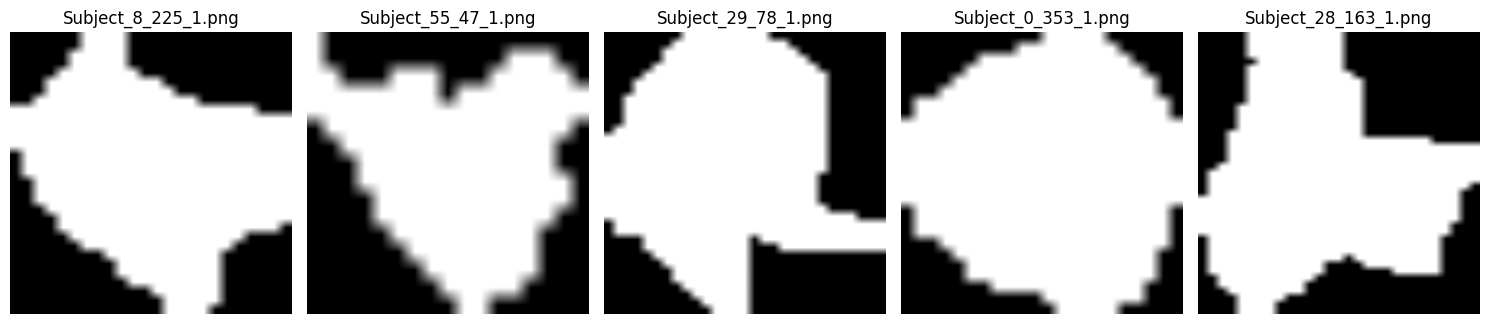

In [5]:
show_random_cropped_images(cropped_images_root="/kaggle/working/cropped_masks_train", num_images=5)


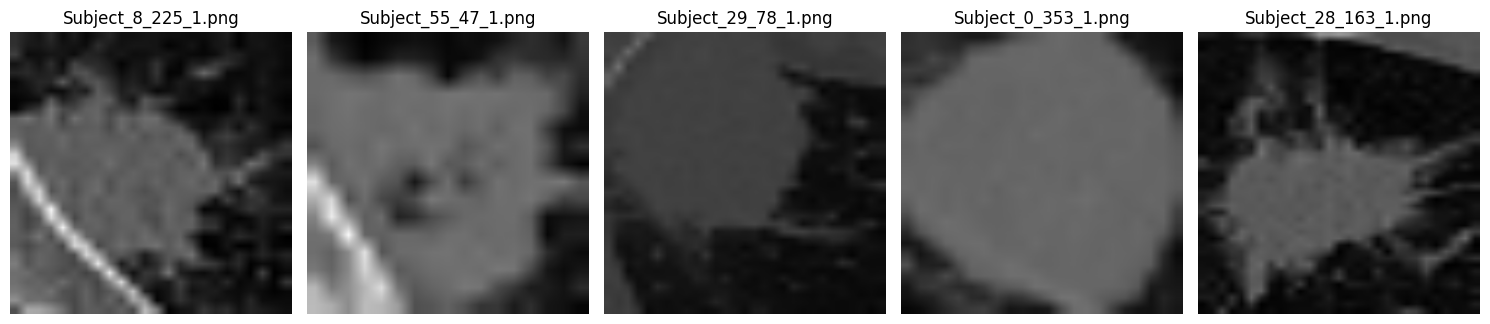

In [6]:
show_random_cropped_images(cropped_images_root="/kaggle/working/cropped_images_train", num_images=5)


In [7]:
import os
import shutil

def move_and_rename_images(source_dir, destination_dir):
    # Ensure the destination directory exists
    os.makedirs(destination_dir, exist_ok=True)

    # Iterate through the directories in the source
    for subject_folder in os.listdir(source_dir):
        subject_path = os.path.join(source_dir, subject_folder)
        
        if os.path.isdir(subject_path):
            # Extract the subject number (e.g., "Subject_0" -> "0")
            subject_number = subject_folder.split('_')[-1]
            
            # Iterate through images in the subject folder
            for image_file in os.listdir(subject_path):
                image_path = os.path.join(subject_path, image_file)
                
                if os.path.isfile(image_path):
                    # Extract the image number and rename it
                    image_number = os.path.splitext(image_file)[0]
                    new_image_name = f"{subject_number}_{image_number}.png"
                    new_image_path = os.path.join(destination_dir, new_image_name)
                    
                    # Move the image to the new location
                    shutil.move(image_path, new_image_path)

    print(f"Images moved successfully to {destination_dir}!")



In [8]:
source_directory = "/kaggle/working/cropped_masks_train"
destination_directory = "/kaggle/working/train/masks"
move_and_rename_images(source_directory, destination_directory)


Images moved successfully to /kaggle/working/train/masks!


In [9]:
source_directory = "/kaggle/working/cropped_images_train"
destination_directory = "/kaggle/working/train/images"
move_and_rename_images(source_directory, destination_directory)


Images moved successfully to /kaggle/working/train/images!


In [10]:
# Example usage
crop_and_resize_images(
    images_root="/kaggle/input/computer-vision-project/val/images",
    masks_root="/kaggle/input/computer-vision-project/val/masks",
    detections_root="/kaggle/input/computer-vision-project/val/detections",
    output_images_root="/kaggle/working/cropped_images_val",
    output_masks_root="/kaggle/working/cropped_masks_val",
    resize_shape=(256, 256)  # Resize to 256x256
)

Processed 204.png for patient Subject_57
Processed 213.png for patient Subject_57
Skipping 100.png for Subject_57: Missing detection or mask
Processed 211.png for patient Subject_57
Processed 209.png for patient Subject_57
Processed 218.png for patient Subject_57
Skipping 1.png for Subject_57: Missing detection or mask
Processed 215.png for patient Subject_57
Skipping 10.png for Subject_57: Missing detection or mask
Processed 208.png for patient Subject_57
Processed 214.png for patient Subject_57
Processed 202.png for patient Subject_57
Processed 216.png for patient Subject_57
Processed 203.png for patient Subject_57
Skipping 101.png for Subject_57: Missing detection or mask
Processed 210.png for patient Subject_57
Processed 201.png for patient Subject_57
Processed 212.png for patient Subject_57
Processed 207.png for patient Subject_57
Processed 206.png for patient Subject_57
Processed 205.png for patient Subject_57
Skipping 0.png for Subject_57: Missing detection or mask
Processed 217

In [11]:
source_directory = "/kaggle/working/cropped_masks_val"
destination_directory = "/kaggle/working/val/masks"
move_and_rename_images(source_directory, destination_directory)


Images moved successfully to /kaggle/working/val/masks!


In [12]:
source_directory = "/kaggle/working/cropped_images_val"
destination_directory = "/kaggle/working/val/images"
move_and_rename_images(source_directory, destination_directory)


Images moved successfully to /kaggle/working/val/images!


# Pre Processing

In [14]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (256, 256), method="nearest")
    input_mask = tf.image.resize(input_mask, (256, 256), method="nearest")

    return input_image, input_mask 

In [15]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [16]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 255.0
  
    return input_image, input_mask

# Create Dataset

In [19]:
def load_image_train(image_path, mask_path):
    # Load the image and mask
    input_image = tf.io.read_file(image_path)
    input_image = tf.image.decode_jpeg(input_image, channels=1)  
    
    input_mask = tf.io.read_file(mask_path)
    input_mask = tf.image.decode_png(input_mask, channels=1)

    # Resize the image and mask
    input_image, input_mask = resize(input_image, input_mask)

    # Apply augmentation (random transformations)
    input_image, input_mask = augment(input_image, input_mask)

    # Normalize the images and masks
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


In [ ]:
def create_dataset_train(image_dir, mask_dir, batch_size=32, target_size=(256, 256)):

    image_files = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')])
    mask_files = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith('.png')])

    # Ensure that each image has a corresponding mask
    if len(image_files) != len(mask_files):
        raise ValueError("The number of images does not match the number of masks.")

    # Create a dataset from image and mask file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))

    # Map the load_image_train function to the dataset
    dataset = dataset.map(lambda x, y: load_image_train(x, y),
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle, batch, and prefetch for performance
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


In [20]:
# Custom image loading function
def load_image_val(image_path, mask_path):
    # Load the image and mask
    input_image = tf.io.read_file(image_path)
    input_image = tf.image.decode_jpeg(input_image, channels=1)  # Assuming the images are in JPEG format

    input_mask = tf.io.read_file(mask_path)
    input_mask = tf.image.decode_png(input_mask, channels=1)  # Assuming masks are in PNG format with 1 channel

    # Resize the image and mask
    input_image, input_mask = resize(input_image, input_mask)

    # Apply augmentation (random transformations)
    # input_image, input_mask = augment(input_image, input_mask)

    # Normalize the images and masks
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask



In [ ]:
def create_dataset_val(image_dir, mask_dir, batch_size=32, target_size=(256, 256)):

    image_files = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')])
    mask_files = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith('.png')])

    # Ensure that each image has a corresponding mask
    if len(image_files) != len(mask_files):
        raise ValueError("The number of images does not match the number of masks.")

    # Create a dataset from image and mask file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))

    # Map the load_image_train function to the dataset
    dataset = dataset.map(lambda x, y: load_image_val(x, y),
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle, batch, and prefetch for performance
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


# Model

In [13]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

def SE(inputs, ratio=8):
    ## [8, H, W, 32]
    channel_axis = -1
    num_filters = inputs.shape[channel_axis]
    se_shape = (1, 1, num_filters)

    x = L.GlobalAveragePooling2D()(inputs) ## [8, 32]
    x = L.Reshape(se_shape)(x)
    x = L.Dense(num_filters // ratio, activation='relu', use_bias=False)(x)
    x = L.Dense(num_filters, activation='sigmoid', use_bias=False)(x)

    x = L.Multiply()([inputs, x])
    return x


def stem_block(inputs, num_filters):
    ## Conv 1
    x = L.Conv2D(num_filters, 3, padding="same")(inputs)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)

    ## Shortcut
    s = L.Conv2D(num_filters, 1, padding="same")(inputs)

    ## Add
    x = L.Add()([x, s])
    return x

def resnet_block(inputs, num_filters, strides=1):
    ## SE
    inputs = SE(inputs)

    ## Conv 1
    x = L.BatchNormalization()(inputs)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same", strides=strides)(x)

    ## Conv 2
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same", strides=1)(x)

    ## Shortcut
    s = L.Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    ## Add
    x = L.Add()([x, s])

    return x

def aspp_block(inputs, num_filters):
    x1 = L.Conv2D(num_filters, 3, dilation_rate=6, padding="same")(inputs)
    x1 = L.BatchNormalization()(x1)

    x2 = L.Conv2D(num_filters, 3, dilation_rate=12, padding="same")(inputs)
    x2 = L.BatchNormalization()(x2)

    x3 = L.Conv2D(num_filters, 3, dilation_rate=18, padding="same")(inputs)
    x3 = L.BatchNormalization()(x3)

    x4 = L.Conv2D(num_filters, (3, 3), padding="same")(inputs)
    x4 = L.BatchNormalization()(x4)

    y = L.Add()([x1, x2, x3, x4])
    y = L.Conv2D(num_filters, 1, padding="same")(y)

    return y

def attetion_block(x1, x2): #Focuses on important features by learning attention maps
    num_filters = x2.shape[-1]

    x1_conv = L.BatchNormalization()(x1)
    x1_conv = L.Activation("relu")(x1_conv)
    x1_conv = L.Conv2D(num_filters, 3, padding="same")(x1_conv)
    x1_pool = L.MaxPooling2D((2, 2))(x1_conv)

    x2_conv = L.BatchNormalization()(x2)
    x2_conv = L.Activation("relu")(x2_conv)
    x2_conv = L.Conv2D(num_filters, 3, padding="same")(x2_conv)

    x = L.Add()([x1_pool, x2_conv])

    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)

    x = L.Multiply()([x, x2])
    return x

def resunet_pp(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """ #Extract hierarchical features.
    c1 = stem_block(inputs, 16) # convolutional block to extract low-level features
    c2 = resnet_block(c1, 32, strides=2) # block with skip connections and Output is the element-wise sum of the convolutions and the shortcut.
    c3 = resnet_block(c2, 64, strides=2)
    c4 = resnet_block(c3, 128, strides=2)

    """ Bridge """ # Bottleneck to capture multi-scale context
    b1 = aspp_block(c4, 256) #dilated convolutions are employed in the residual blocks to capture multi-scale features
                            # dilation rate controls the spacing between kernel elements
    
    """ Decoder """ #Upsample and refine features
    d1 = attetion_block(c3, b1)
    d1 = L.UpSampling2D((2, 2))(d1)
    d1 = L.Concatenate()([d1, c3])
    d1 = resnet_block(d1, 128)

    d2 = attetion_block(c2, d1)
    d2 = L.UpSampling2D((2, 2))(d2)
    d2 = L.Concatenate()([d2, c2])
    d2 = resnet_block(d2, 64)

    d3 = attetion_block(c1, d2)
    d3 = L.UpSampling2D((2, 2))(d3)
    d3 = L.Concatenate()([d3, c1])
    d3 = resnet_block(d3, 32)

    """ Output"""
    outputs = aspp_block(d3, 16)
    outputs = L.Conv2D(1, 1, padding="same")(outputs)
    outputs = L.Activation("sigmoid")(outputs)

    """ Model """
    model = Model(inputs, outputs)
    return model


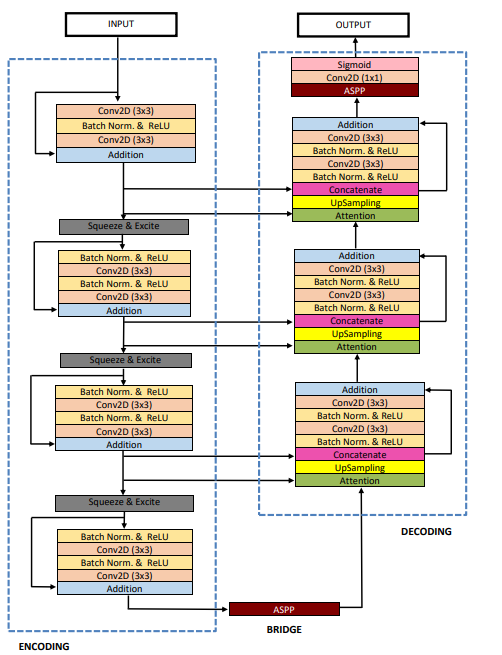

In [22]:
import tensorflow as tf
from tensorflow.keras import backend as K

class BCEDiceLoss(tf.keras.losses.Loss):
    def __init__(self, epsilon=1e-6, prob_of_bce=0.4, **kwargs):
        super(BCEDiceLoss, self).__init__(**kwargs)
        self.epsilon = epsilon
        self.prob_of_bce = prob_of_bce
        self.bce = tf.keras.losses.BinaryCrossentropy()

    def call(self, y_true, y_pred):
        # Binary cross-entropy loss from logits
        bce_loss = self.bce(y_true, y_pred)
        
        # Sigmoid for Dice loss
        # y_pred = tf.sigmoid(y_pred)

        y_pred = tf.reshape(y_pred, [-1])
        y_true = tf.reshape(y_true, [-1])

        # Compute Dice coefficient
        intersection = tf.reduce_sum(y_pred * y_true)
        union = tf.reduce_sum(y_pred) + tf.reduce_sum(y_true)
        dice = (2. * intersection + self.epsilon) / (union + self.epsilon)
        
        # Dice loss is 1 - Dice coefficient
        dice_loss = 1 - dice

        return (self.prob_of_bce * bce_loss) + dice_loss


In [23]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


In [24]:
# import tensorflow as tf

# def bce_jaccard_loss(y_true, y_pred, smooth=1e-5):
#     # Binary Cross-Entropy Loss
#     bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    
#     # Jaccard Index (Intersection over Union)
#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
#     jac = intersection / (union + smooth)
    
#     # BCE + Jaccard Loss
#     return bce - tf.math.log(jac + smooth)


In [25]:

import logging

logging.basicConfig(filename='/kaggle/working/training_logs.txt', 
                    level=logging.INFO,
                    format='%(asctime)s - %(message)s')

# Log a message
logging.info('Training started')


image_dir_train = "/kaggle/working/train/images"
mask_dir_train = "/kaggle/working/train/masks"

image_dir_val = "/kaggle/working/val/images"
mask_dir_val = "/kaggle/working/val/masks"


resize_shape = (256, 256) 
batch_size = 64
epochs = 500


train_dataset = create_dataset_train(image_dir_train, mask_dir_train)
val_dataset = create_dataset_val(image_dir_val, mask_dir_val)


unet_model = resunet_pp(input_shape=(resize_shape[0], resize_shape[1], 1))

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'bi_loss_20_epoch_cropp_segmentation_Unet.keras', 
    verbose=1, 
    save_best_only=True, 
    monitor='val_loss',
    mode='min' 
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', mode='min'), 
    tf.keras.callbacks.TensorBoard(log_dir='logs'), 
    checkpointer
]

lr = 0.001

# Compile the model
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=BCEDiceLoss(epsilon=1e-6, prob_of_bce=0.9), 
                   metrics=["accuracy", dice_coefficient]) 

model_history = unet_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks
)


Epoch 1/500


I0000 00:00:1734477703.443236      89 service.cc:145] XLA service 0x7a60dc002d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734477703.443300      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-12-17 23:22:26.946812: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,160,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,160,128,128]{3,2,1,0}, f32[32,64,128,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-17 23:22:27.802672: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.856073232s
Trying algorithm eng0{} for co

52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.5921 - dice_coefficient: 0.6507 - loss: 0.9045

I0000 00:00:1734477841.598453      89 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_225', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill s

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5922 - dice_coefficient: 0.6514 - loss: 0.9034   
Epoch 1: val_loss improved from inf to 0.76829, saving model to bi_loss_20_epoch_cropp_segmentation_Unet.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.5923 - dice_coefficient: 0.6520 - loss: 0.9023 - val_accuracy: 0.5834 - val_dice_coefficient: 0.7328 - val_loss: 0.7683
Epoch 2/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.6329 - dice_coefficient: 0.7671 - loss: 0.7033
Epoch 2: val_loss improved from 0.76829 to 0.76451, saving model to bi_loss_20_epoch_cropp_segmentation_Unet.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 592ms/step - accuracy: 0.6333 - dice_coefficient: 0.7673 - loss: 0.7026 - val_accuracy: 0.5834 - val_dice_coefficient: 0.7388 - val_loss: 0.7645
Epoch 3/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.6901 - dice_coefficient: 0.8161 - loss: 0.5469
Epoch 3: val_loss did not improve from 0.76451
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 581ms/step - acc

# Helper Functions


In [27]:
def create_mask(pred_mask, threshold=0.5):
    pred_mask = tf.where(pred_mask > threshold, 1, 0)
    return pred_mask[0]  # Return the first mask in the batch


In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def show_predictions(dataset, num=1, model=None):
    if model is None:
        raise ValueError("A model must be provided for predictions.")
    
    count = 0 
    for batch_images, batch_masks in dataset:
        for image, mask in zip(batch_images, batch_masks):
            if count >= num: 
                return
            
            pred_mask = model.predict(image[tf.newaxis, ...], verbose=0)  # Shape: (1, 256, 256, 1)
            
            binary_mask = create_mask(pred_mask)
            
            # Convert images and masks to grayscale if they are not already
            image_gray = np.squeeze(image, axis=-1) if len(image.shape) == 3 else image
            mask_gray = np.squeeze(mask, axis=-1) if len(mask.shape) == 3 else mask
            binary_mask_gray = np.squeeze(binary_mask, axis=-1) if len(binary_mask.shape) == 3 else binary_mask

            # Add a channel dimension to make it (height, width, 1)
            image_gray = np.expand_dims(image_gray, axis=-1)
            mask_gray = np.expand_dims(mask_gray, axis=-1)
            binary_mask_gray = np.expand_dims(binary_mask_gray, axis=-1)
            
            display([image_gray, mask_gray, binary_mask_gray])
            
            count += 1

def display(display_list):
    """Helper function to display images"""
    plt.figure(figsize=(15, 5))
    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].squeeze(), cmap="gray") 
        plt.axis("off")
    plt.show()


In [29]:
unet_model.save('/kaggle/working/resnetUnetPP256.h5')


In [30]:
# unet_model.save_weights('/kaggle/working/resnetUnetPP256_weights.h5')

ValueError: The filename must end in `.weights.h5`. Received: filepath=/kaggle/working/resnetUnetPP256_weights.h5

In [ ]:
# Example usage of `show_predictions` with a validation dataset
show_predictions(dataset=val_dataset, num=3, model=unet_model)


In [ ]:
import matplotlib.pyplot as plt

def display_learning_curves(history):
    acc = history.history.get("accuracy", None)
    val_acc = history.history.get("val_accuracy", None)
    loss = history.history.get("loss", None)
    val_loss = history.history.get("val_loss", None)
    dice = history.history.get("dice_coefficient", None)
    val_dice = history.history.get("val_dice_coefficient", None)

    if acc is None or loss is None:
        print("Accuracy or Loss data not available in history.")
        return

    epochs_range = range(len(acc))

    fig = plt.figure(figsize=(12, 6))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Train Accuracy")
    if val_acc is not None:
        plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Train Loss")
    if val_loss is not None:
        plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

    # Plot Dice coefficient if available
    if dice is not None:
        plt.figure(figsize=(8, 6))
        plt.plot(epochs_range, dice, label="Train Dice Coefficient")
        if val_dice is not None:
            plt.plot(epochs_range, val_dice, label="Validation Dice Coefficient")
        plt.title("Dice Coefficient")
        plt.xlabel("Epoch")
        plt.ylabel("Dice Coefficient")
        plt.legend(loc="upper right")
        plt.show()

# Example usage:
display_learning_curves(model_history)


In [ ]:
print(model_history.history.keys())
